<a href="https://colab.research.google.com/github/PPierzc/PracowniaEEG/blob/master/ERD_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ERD/S

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss

sns.set()
sns.set_context("talk", font_scale=1.4)

## SignalManager
Klasa do zarządazania sygnałem.

Wczytuje dane ze svaroga lub z generatora (słownika o odpowiednich danych)

In [0]:
class SignalManager(object):
  def __init__(self, name='', **kwargs):
    self.name = name

    if 'filename' in kwargs:
      filename = kwargs['filename']
      extentions = ['.xml', '.raw', '.tag']

      mgr = ReadManager("%s.xml"%filename, "%s.raw"%filename, "%s.tag"%filename)

      self.fs = int(float(mgr.get_param("sampling_frequency")))

      self.num_channels = int(mgr.get_param("number_of_channels"))
      self.channels_names = mgr.get_param("channels_names")

      self.data = mgr.get_microvolt_samples()
      self.t = np.arange(self.data.shape[1]) / self.fs

      self.epochs = 1
      self.tags = []
    
    if 'generator' in kwargs:
      generator = kwargs['generator']
    
      self.fs = generator['fs']

      self.num_channels = generator['num_channels']
      self.channel_names = generator['channel_names']

      self.data = generator['data']
      self.t = generator['t']

      self.epochs = generator['epochs']
      self.tags = generator['tags']
    
  def set_tags_from_channel(self, channel_name):
    tag_channel = self.data[:, self.channel_names.index(channel_name)]
    
    tag_channel = tag_channel / np.max(tag_channel)
    
    self.tags = np.where(tag_channel > 0.9)[1]
  
  def set_epochs_from_tags(self, low, high):
    self.t = np.arange(low, high, 1/self.fs)
    
    low = int(low * self.fs)
    high = int(high * self.fs)
    
    length = high - low
    data = np.zeros((len(self.tags), self.num_channels, high - low))
    
    for idx, tag in enumerate(self.tags):
      data[idx] = self.data[:, :, tag+low : tag+high]
      
    self.data = data
    self.tags = []
    
  def welch_spectrum(self):
    spectrum_freqs, spectrum = ss.welch(self.data, self.fs)
    
    self.spectrum = spectrum
    self.spectrum_freqs = spectrum_freqs
  
  
  def spectrum_plot(self, fig, ax, title='', color='#ff0641', *args, **kwargs):
    plt.style.use('classic')
    
    for epoch in self.spectrum:
      for idx, channel in enumerate(epoch):
        ax[idx].plot(
            self.spectrum_freqs,
            channel,
            color=color,
            *args,
            **kwargs
        )

        ax[idx].margins(0.1, 0.1)

        ax[idx].set_title(
            self.channel_names[idx],
            fontsize=20
        )
        ax[idx].set_facecolor('#ffedf1')
        ax[idx].tick_params(labelsize=14)
        ax[idx].grid(True, color='r')

        fig.text(
            0.5,
            0.05,
            'Cześtotliwość [Hz]',
            ha='center',
            fontsize=20
        )
        fig.text(
            0.5,
            0.95,
            title,
            ha='center',
            fontsize=20
        )
        fig.text(
            0.04,
            0.5,
            'Amplituda [$\mu$V]',
            va='center',
            rotation='vertical',
            fontsize=20
        )

        fig.patch.set_facecolor('#ffffff')
  
  def time_plot(self, fig, ax, title='', color='#ff0641', *args, **kwargs):
    plt.style.use('classic')
    
    for epoch in self.data:
      for idx, channel in enumerate(epoch):
        ax[idx].plot(
            self.t,
            channel,
            color=color,
            *args,
            **kwargs
        )

        for tag in self.tags:
          ax[idx].axvline(
            tag / self.fs,
            color='#000000',
            ls = '--'
          )

        ax[idx].margins(0.1, 0.1)

        ax[idx].set_title(
            self.channel_names[idx],
            fontsize=20
        )
        ax[idx].set_facecolor('#ffedf1')
        ax[idx].tick_params(labelsize=14)
        ax[idx].grid(True, color='r')

        fig.text(
            0.5,
            0.05,
            'Czas [s]',
            ha='center',
            fontsize=20
        )
        fig.text(
            0.5,
            0.95,
            title,
            ha='center',
            fontsize=20
        )
        fig.text(
            0.04,
            0.5,
            'Wartość Sygnału [$\mu$V]',
            va='center',
            rotation='vertical',
            fontsize=20
        )

        fig.patch.set_facecolor('#ffffff')
    
  def copy(self, name=''):
    return SignalManager(name=name, generator={
      'fs': self.fs,
      'num_channels': self.num_channels,
      'channel_names': self.channel_names,
      'epochs': self.epochs,
      'data': self.data,
      't': self.t,
      'tags': self.tags
    })

In [0]:
def sin(t, f):
  return np.sin(2 * np.pi * f * t)

def noise(t, loc=0, scale=1):
  return np.random.normal(loc=loc, scale=scale, size=len(t))

## Wyznaczanie pasma $\mu$ i $\beta$.

In [0]:
def generate_signal():
  data = {
      'fs': 512,
      'num_channels': 3,
      'channel_names': ['C3', 'C4', 'd1'],
      'epochs': 1
  }
  
  T = 20
  t = np.arange(0, T, 1 / data['fs'])
  
  mu_freq = 10
  beta_freq = 23
  net_freq = 50
  
  data['data'] = np.zeros((data['epochs'], data['num_channels'], len(t)))
  
  for epoch in range(data['epochs']):
    data['data'][epoch][0] += (0.1 * t + 0.1) * sin(t, mu_freq)
    data['data'][epoch][0] += (0.1 * t + 0.1) * sin(t, beta_freq)
    data['data'][epoch][0] += sin(t, net_freq)
    data['data'][epoch][0] += 0.3 * noise(t)

    data['data'][epoch][1] += (0.1 * t + 0.1) * sin(t, mu_freq)
    data['data'][epoch][1] += (0.1 * t + 0.1) * sin(t, beta_freq)
    data['data'][epoch][1] += sin(t, net_freq)
    data['data'][epoch][1] += 0.3 * noise(t)

    data['data'][epoch][2][::5*data['fs']] = 1
    data['data'][epoch][2][0] = 0
    
  data['t'] = t
  data['tags'] = []
  
  return data

In [0]:
EEG = SignalManager(generator=generate_signal())
EEG.set_tags_from_channel('d1')

PRE_EEG = EEG.copy('pre')
PRE_EEG.set_epochs_from_tags(-4, -2)

PRE_EEG.welch_spectrum()
PRE_EEG.spectrum = np.mean(PRE_EEG.spectrum, axis=0)
PRE_EEG.spectrum = np.reshape(PRE_EEG.spectrum, (1, *PRE_EEG.spectrum.shape))

POST_EEG = EEG.copy('post')
POST_EEG.set_epochs_from_tags(0.5, 2.5)

POST_EEG.welch_spectrum()
POST_EEG.spectrum = np.mean(POST_EEG.spectrum, axis=0)
POST_EEG.spectrum = np.reshape(POST_EEG.spectrum, (1, *POST_EEG.spectrum.shape))


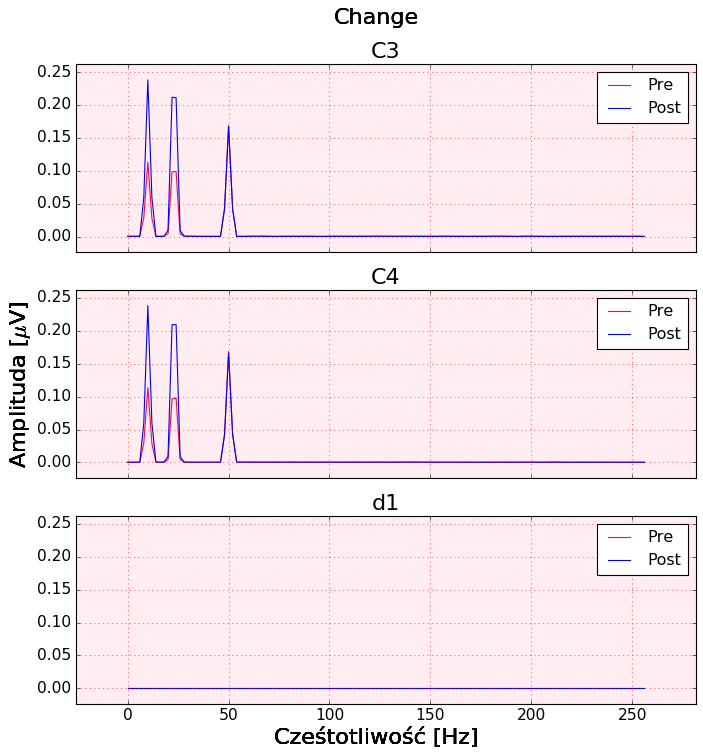

In [55]:
fig, ax = plt.subplots(
    nrows=PRE_EEG.num_channels,
    ncols=1,
    sharex=True,
    sharey=True,
    figsize=(10, 10)
)

PRE_EEG.spectrum_plot(
    fig,
    ax,
    'Change',
    label='Pre'
)
POST_EEG.spectrum_plot(
    fig,
    ax,
    color='#0000ff',
    label='Post'
)

for a in ax:
  a.legend()

plt.show()
plt.close()